In [ ]:
!sudo apt-get update
!sudo apt-get install stockfish

In [ ]:
!pip install --upgrade pip
!pip install chess zstandard

Edit pgn file to remove unnecessary details

In [ ]:
import re


In [ ]:

def reinstate_move_numbers(moves):
    tokens = moves.strip().split()
    result = []
    for i in range(0, len(tokens), 2):
        move_number = i // 2 + 1
        if i + 1 < len(tokens):
            result.append(f"{move_number}. {tokens[i]} {tokens[i+1]}")
        else:
            result.append(f"{move_number}. {tokens[i]}")
    return " ".join(result)

def clean_and_reformat_pgn(pgn_text):
    games = re.split(r'\n\s*\n', pgn_text.strip())

    cleaned_games = []

    for game in games:
        header_lines = []
        move_lines = []

        for line in game.strip().splitlines():
            if line.startswith('['):
                header_lines.append(line)
            else:
                move_lines.append(line)

        header = "\n".join(header_lines)
        moves_raw = " ".join(move_lines)

        # Remove unnecessary symbols (information)
        moves = re.sub(r"\{[^}]*\}", "", moves_raw)
        
        moves = re.sub(r"\d+\.\.\.", "", moves)
        
        moves = re.sub(r"\d+\.", "", moves)
        
        moves = re.sub(r"\s+", " ", moves).strip()
        
        moves_numbered = reinstate_move_numbers(moves)

        cleaned_game = f"{header}\n\n{moves_numbered}"
        cleaned_games.append(cleaned_game)

    return "\n\n".join(cleaned_games)

# Load pgn
with open("/workspaces/ChessSeminar/lichess_sample_10000.pgn", "r", encoding="utf-8") as file:
    raw_pgn = file.read()

# Change pgn
cleaned_pgn = clean_and_reformat_pgn(raw_pgn)

# Write in new pgn
with open("/workspaces/ChessSeminar/cleaned.pgn", "w", encoding="utf-8") as out_file:
    out_file.write(cleaned_pgn)



Reduce empty lines in pgn

In [ ]:
def reduce_blank_lines_in_pgn(input_path, output_path):
    with open(input_path, "r", encoding="utf-8") as infile:
        lines = infile.readlines()

    cleaned_lines = []
    current_game = []
    blank_line_count = 0

    def flush_game(game_lines):
        cleaned = []
        header_ended = False
        blank_line_count = 0
        for line in game_lines:
            stripped = line.strip()
            if stripped.startswith("["):  
                cleaned.append(line)
                header_ended = False
                blank_line_count = 0
            elif stripped == "":
                if not header_ended:
                    if blank_line_count == 0:
                        cleaned.append("\n")
                    blank_line_count += 1
                    header_ended = True
            else:
                cleaned.append(line)
                blank_line_count = 0
        cleaned.append("\n")  # Game end: one empty line
        return cleaned

    for line in lines:
        if line.strip() == "" and not current_game:
            # Emptly line game beginning -> continiue
            continue
        current_game.append(line)
        if line.strip().startswith("[Event") and len(current_game) > 1:
            # New game starts, evaluate last game
            cleaned_lines.extend(flush_game(current_game[:-1]))
            current_game = [line]

    if current_game:
        cleaned_lines.extend(flush_game(current_game))

    with open(output_path, "w", encoding="utf-8") as outfile:
        outfile.writelines(cleaned_lines)
reduce_blank_lines_in_pgn("/workspaces/ChessSeminar/cleaned.pgn", "cleaned_one_line.pgn")

Game Opening Function

In [ ]:
import chess
import chess.pgn

# Elo scales, 1978 FIDE
def get_elo_bucket(elo):
    if elo < 1000:
        return "beginner"  # Novices
    elif elo < 1400:
        return "intermediate"  # Class E and D
    elif elo < 1800:
        return "club_player"  # Class C and B
    elif elo < 2200:
        return "advanced"  # Class A and Experts
    else:
        return "expert"  # Masters

# Convert game result into a label (perspective white)
def result_to_label(result, player):
    if result == "1-0":
        return "win" if player == "white" else "loss"
    elif result == "0-1":
        return "win" if player == "black" else "loss"
    elif result == "1/2-1/2":
        return "draw"
    else:
        return "unknown"

# Analyze opening phase of a game with engine comparison
def analyze_opening(game, engine, game_nr, depth=15):
    board = game.board()
    moves = []

    white_elo = int(game.headers.get("WhiteElo", 0))
    black_elo = int(game.headers.get("BlackElo", 0))
    result = game.headers.get("Result", "*")

    total_plies = len(list(game.mainline_moves()))
    opening_limit = int(total_plies * 0.3)
    sequence = []
    engine_sequence = []

    for ply, move in enumerate(game.mainline_moves()):
        if ply >= opening_limit:
            break

        san_move = board.san(move)
        sequence.append(san_move)

        player_color = board.turn  # Save before pushing
        player = "white" if player_color == chess.WHITE else "black"

        # Engine analysis before move
        info_before = engine.analyse(board, chess.engine.Limit(depth=depth))
        best_move = info_before["pv"][0] if "pv" in info_before else None

        if best_move:
            best_board = board.copy()
            best_board.push(best_move)
            info_best = engine.analyse(best_board, chess.engine.Limit(depth=depth))
            score_best = (
                info_best["score"].pov(player_color).score(mate_score=10000)
                if not info_best["score"].is_mate()
                else 10000
            )
            engine_sequence.append(board.san(best_move))
        else:
            score_best = None
            engine_sequence.append(None)

        board.push(move)

        # Engine analysis after move
        info_after = engine.analyse(board, chess.engine.Limit(depth=depth))
        score_after = (
            info_after["score"].pov(player_color).score(mate_score=10000)
            if not info_after["score"].is_mate()
            else 10000
        )

        move_quality = (
            0 if best_move == move else abs(score_after - score_best) if score_best is not None else None
        )

        moves.append({
            "ply": ply,
            "move": san_move,
            "move_quality": move_quality,
            "player": player
        })

    return {
        "game_nr": game_nr,
        "white_elo": white_elo,
        "black_elo": black_elo,
        "elo_level_white": get_elo_bucket(white_elo),
        "elo_level_black": get_elo_bucket(black_elo),
        "result": result,
        "human_opening_sequence": " ".join(sequence),
        "engine_opening_sequence": " ".join(engine_sequence),
        "moves": moves
    }


Save in json

In [ ]:
import json
import os
import chess
import chess.engine
import chess.pgn
from io import StringIO

DATA_FILE = "/workspaces/ChessSeminar/chess_data_opening_15_4500_5000.json"
PGN_FILE = "/workspaces/ChessSeminar/cleaned_one_line.pgn"
ENGINE_PATH = "/usr/games/stockfish"
MAX_GAMES = 10000
SKIP_GAMES = 4500  # Number of games to skip before starting analysis

def save_data(new_data):
    if os.path.exists(DATA_FILE):
        with open(DATA_FILE, "r") as f:
            existing_data = json.load(f)
    else:
        existing_data = []

    existing_data.extend(new_data)

    with open(DATA_FILE, "w") as f:
        json.dump(existing_data, f, indent=2)

def load_data():
    if os.path.exists(DATA_FILE):
        with open(DATA_FILE, "r") as f:
            return json.load(f)
    else:
        return []

# Load engine
engine = chess.engine.SimpleEngine.popen_uci(ENGINE_PATH)

# Load existing data
all_data = load_data()

# Determine the last game number already analyzed
last_game_nr = max((d["game_nr"] for d in all_data), default=0)
current_game_nr = last_game_nr

game_count = 0

with open(PGN_FILE) as pgn:
    # Skip games: either from saved point or 4500 manually specified, whichever is greater
    skip_total = max(current_game_nr, SKIP_GAMES)
    print(f"Skipping the first {skip_total} games...")
    for _ in range(skip_total):
        if chess.pgn.read_game(pgn) is None:
            break  # Stop if we hit end of file while skipping

    while game_count < MAX_GAMES:
        game = chess.pgn.read_game(pgn)
        if game is None:
            print("No more games to read.")
            break

        game_count += 1
        current_game_nr = last_game_nr + game_count
        print(f"Analyzing game {current_game_nr}...")

        try:
            new_game_data = analyze_opening(game, engine, game_nr=current_game_nr)

            total_plies = len(list(game.mainline_moves()))
            opening_limit = int(total_plies * 0.3)

            if len(new_game_data["moves"]) == opening_limit:
                save_data([new_game_data])
                print(f"Game {current_game_nr} saved.")
            else:
                print(f"Game {current_game_nr} NOT saved (incomplete opening analysis).")

        except KeyboardInterrupt:
            print("Analysis interrupted by user.")
            break
        except Exception as e:
            print(f"Error analyzing game {current_game_nr}: {e}")

engine.quit()


Load Data

In [1]:
import json

# List of JSON files to load
json_files = [
    "/workspaces/ChessSeminar/chess_data_opening_15_4000_4500.json",
    "/workspaces/ChessSeminar/chess_data_opening_15_4500_5000.json",
    "/workspaces/ChessSeminar/chess_data_opening_15_to_4000.json",
    "/workspaces/ChessSeminar/chess_data_opening_15_to2500.json",
]

all_data = []

# Load and combine data from each file
for filename in json_files:
    try:
        with open(filename, "r") as f:
            data = json.load(f)
            all_data.extend(data)
            print(f"Loaded {len(data)} records from {filename}")
    except FileNotFoundError:
        print(f"File not found: {filename}")
    except json.JSONDecodeError:
        print(f"Invalid JSON format in: {filename}")


Loaded 500 records from /workspaces/ChessSeminar/chess_data_opening_15_4000_4500.json
Loaded 500 records from /workspaces/ChessSeminar/chess_data_opening_15_4500_5000.json
Loaded 1500 records from /workspaces/ChessSeminar/chess_data_opening_15_to_4000.json
Loaded 2547 records from /workspaces/ChessSeminar/chess_data_opening_15_to2500.json


Analysis opening phase

In [2]:
# Initialize counters
total_quality = 0
count = 0
# Iterate through games
for game in data:
    moves = game.get("moves", [])
    for move in moves:
        mq = move.get("move_quality")
        if mq is not None:
            total_quality += mq
            count += 1

# Calculate and print average
if count > 0:
    avg_quality = total_quality / count
    print(f"Average move quality across all games: {avg_quality:.2f}")
else:
    print("No move_quality data found.")

Average move quality across all games: 40.54


In [3]:
elo_levels = ["beginner", "intermediate", "club_player", "advanced", "expert"]

for level in elo_levels:
    total_quality = 0
    count = 0

    for game in data:
        # For white player
        if game.get("elo_level_white") == level:
            for move in game.get("moves", []):
                if move.get("player") == "white":
                    mq = move.get("move_quality")
                    if mq is not None:
                        total_quality += mq
                        count += 1

        # For black player
        if game.get("elo_level_black") == level:
            for move in game.get("moves", []):
                if move.get("player") == "black":
                    mq = move.get("move_quality")
                    if mq is not None:
                        total_quality += mq
                        count += 1

    # Output combined result
    if count > 0:
        avg_quality = total_quality / count
        print(f"{level}: Combined average move quality (white + black) = {avg_quality:.2f}")
    else:
        print(f"{level}: No move_quality data found.")


beginner: Combined average move quality (white + black) = 40.33
intermediate: Combined average move quality (white + black) = 40.68
club_player: Combined average move quality (white + black) = 42.33
advanced: Combined average move quality (white + black) = 38.48
expert: Combined average move quality (white + black) = 40.27


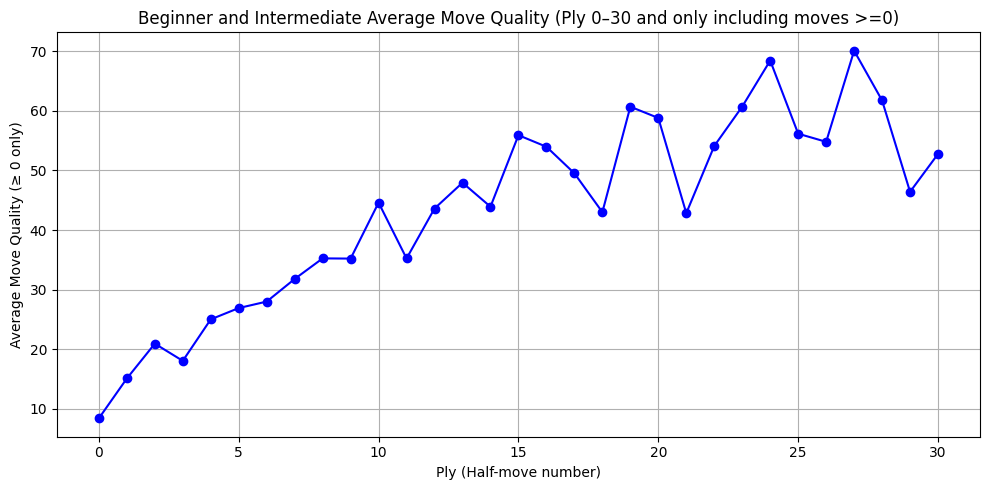

In [4]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Prepare: ply -> list of move qualities (only for beginners, move_quality >= 0)
beginner_quality_by_ply = defaultdict(list)

for game in data:
    white_elo_level = game.get("elo_level_white")
    black_elo_level = game.get("elo_level_black")
    
    for move in game.get("moves", []):
        ply = move.get("ply")
        mq = move.get("move_quality")
        player = move.get("player")

        if ply is None or ply > 30 or mq is None or mq < 0:
            continue

    
        if player == "white" and white_elo_level == "beginner" or white_elo_level == "intermediate":
            beginner_quality_by_ply[ply].append(mq)
        elif player == "black" and black_elo_level == "beginner" or black_elo_level == "intermediate":
            beginner_quality_by_ply[ply].append(mq)

# Compute average move quality per ply
avg_quality_by_ply = {
    ply: sum(vals) / len(vals)
    for ply, vals in beginner_quality_by_ply.items()
    if len(vals) > 0
}

# Sort plies and values for plotting
x = sorted(avg_quality_by_ply.keys())
y = [avg_quality_by_ply[ply] for ply in x]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='o', color='blue')
plt.title("Beginner and Intermediate Average Move Quality (Ply 0–30 and only including moves >=0)")
plt.xlabel("Ply (Half-move number)")
plt.ylabel("Average Move Quality (≥ 0 only)")
plt.grid(True)
plt.tight_layout()
plt.show()


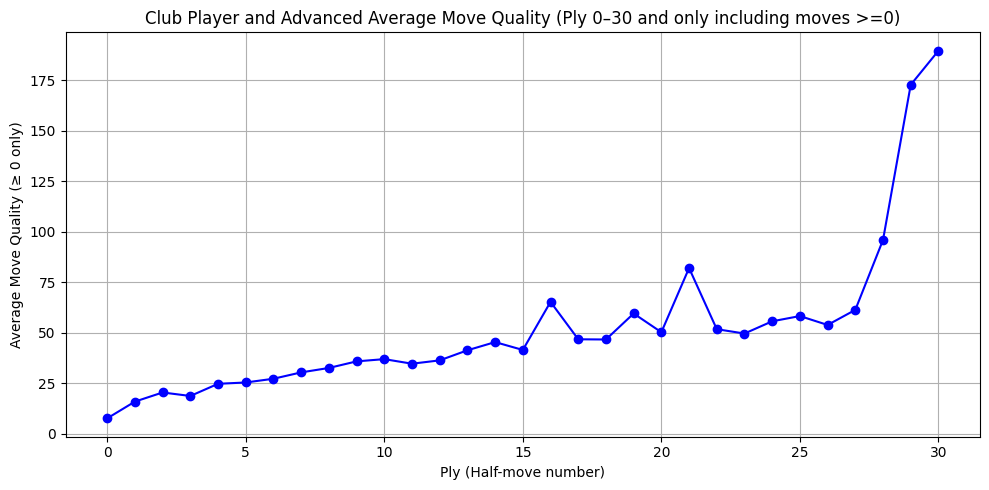

In [5]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Prepare: ply -> list of move qualities (only for beginners, move_quality >= 0)
beginner_quality_by_ply = defaultdict(list)

for game in data:
    white_elo_level = game.get("elo_level_white")
    black_elo_level = game.get("elo_level_black")
    
    for move in game.get("moves", []):
        ply = move.get("ply")
        mq = move.get("move_quality")
        player = move.get("player")

        if ply is None or ply > 30 or mq is None or mq < 0:
            continue

    
        if player == "white" and white_elo_level == "club_player" or white_elo_level == "advanced":
            beginner_quality_by_ply[ply].append(mq)
        elif player == "black" and black_elo_level == "club_player" or black_elo_level == "advanced":
            beginner_quality_by_ply[ply].append(mq)

# Compute average move quality per ply
avg_quality_by_ply = {
    ply: sum(vals) / len(vals)
    for ply, vals in beginner_quality_by_ply.items()
    if len(vals) > 0
}

# Sort plies and values for plotting
x = sorted(avg_quality_by_ply.keys())
y = [avg_quality_by_ply[ply] for ply in x]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='o', color='blue')
plt.title("Club Player and Advanced Average Move Quality (Ply 0–30 and only including moves >=0)")
plt.xlabel("Ply (Half-move number)")
plt.ylabel("Average Move Quality (≥ 0 only)")
plt.grid(True)
plt.tight_layout()
plt.show()


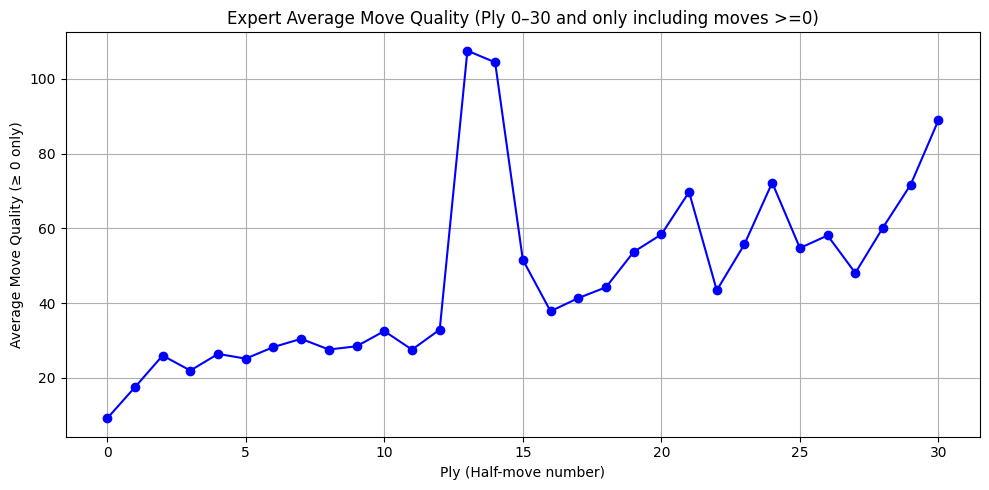

In [6]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Prepare: ply -> list of move qualities (only for beginners, move_quality >= 0)
beginner_quality_by_ply = defaultdict(list)

for game in data:
    white_elo_level = game.get("elo_level_white")
    black_elo_level = game.get("elo_level_black")
    
    for move in game.get("moves", []):
        ply = move.get("ply")
        mq = move.get("move_quality")
        player = move.get("player")

        if ply is None or ply > 30 or mq is None or mq < 0:
            continue

    
        if player == "white" and white_elo_level == "expert":
            beginner_quality_by_ply[ply].append(mq)
        elif player == "black" and black_elo_level == "expert":
            beginner_quality_by_ply[ply].append(mq)

# Compute average move quality per ply
avg_quality_by_ply = {
    ply: sum(vals) / len(vals)
    for ply, vals in beginner_quality_by_ply.items()
    if len(vals) > 0
}

# Sort plies and values for plotting
x = sorted(avg_quality_by_ply.keys())
y = [avg_quality_by_ply[ply] for ply in x]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='o', color='blue')
plt.title("Expert Average Move Quality (Ply 0–30 and only including moves >=0)")
plt.xlabel("Ply (Half-move number)")
plt.ylabel("Average Move Quality (≥ 0 only)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
elo_levels = ["beginner", "intermediate", "club_player", "advanced", "expert"]

# Initialize counters: player_vs_opponent[player_level][opponent_level] = {"wins": 0, "total": 0}
player_vs_opponent = {
    pl: {op: {"wins": 0, "total": 0} for op in elo_levels}
    for pl in elo_levels
}

for game in data:
    result = game.get("result")
    white_level = game.get("elo_level_white")
    black_level = game.get("elo_level_black")

    # White player perspective
    if white_level in elo_levels and black_level in elo_levels:
        player_vs_opponent[white_level][black_level]["total"] += 1
        if result == "1-0":
            player_vs_opponent[white_level][black_level]["wins"] += 1

    # Black player perspective
    if black_level in elo_levels and white_level in elo_levels:
        player_vs_opponent[black_level][white_level]["total"] += 1
        if result == "0-1":
            player_vs_opponent[black_level][white_level]["wins"] += 1

# Print matrix
print("Win Rate Matrix (Player vs Opponent):\n")
header = "Player \\ Opponent".ljust(18) + "".join(f"{op.ljust(14)}" for op in elo_levels)
print(header)
print("-" * len(header))
for pl in elo_levels:
    row = pl.ljust(18)
    for op in elo_levels:
        matchup = player_vs_opponent[pl][op]
        total = matchup["total"]
        wins = matchup["wins"]
        win_rate = (wins / total * 100) if total > 0 else 0
        row += f"{win_rate:6.1f}%".ljust(14)
    print(row)


Win Rate Matrix (Player vs Opponent):

Player \ Opponent beginner      intermediate  club_player   advanced      expert        
----------------------------------------------------------------------------------------
beginner            47.7%         44.7%         50.0%          0.0%          0.0%       
intermediate        46.8%         48.2%         47.0%          0.0%          0.0%       
club_player         50.0%         50.6%         48.7%         41.5%          0.0%       
advanced           100.0%        100.0%         55.1%         47.1%         45.2%       
expert               0.0%        100.0%         81.8%         46.6%         43.8%       


In [8]:
elo_levels = ["beginner", "intermediate", "club_player", "advanced", "expert"]

for level in elo_levels:
    total_quality = 0
    count = 0

    for game in data:
        # Only consider first 5 half moves (ply 0 to 4)
        for move in game.get("moves", []):
            ply = move.get("ply", 999)
            if ply >= 5:
                break  # Stop after first 5 half moves

            mq = move.get("move_quality")
            if mq is None:
                continue

            player = move.get("player")
            # Check if player's elo level matches current level
            if player == "white" and game.get("elo_level_white") == level:
                total_quality += mq
                count += 1
            elif player == "black" and game.get("elo_level_black") == level:
                total_quality += mq
                count += 1

    if count > 0:
        avg_quality = total_quality / count
        print(f"{level}: Combined average move quality (first 5 half-moves) = {avg_quality:.2f}")
    else:
        print(f"{level}: No move_quality data found.")


beginner: Combined average move quality (first 5 half-moves) = 17.99
intermediate: Combined average move quality (first 5 half-moves) = 16.93
club_player: Combined average move quality (first 5 half-moves) = 16.98
advanced: Combined average move quality (first 5 half-moves) = 17.68
expert: Combined average move quality (first 5 half-moves) = 20.14


In [9]:
import numpy as np

elo_levels = ["beginner", "intermediate", "club_player", "advanced", "expert"]

for level in elo_levels:
    move_qualities = []

    for game in data:
        # For white player
        if game.get("elo_level_white") == level:
            for move in game.get("moves", []):
                if move.get("player") == "white":
                    mq = move.get("move_quality")
                    if mq is not None:
                        move_qualities.append(mq)

        # For black player
        if game.get("elo_level_black") == level:
            for move in game.get("moves", []):
                if move.get("player") == "black":
                    mq = move.get("move_quality")
                    if mq is not None:
                        move_qualities.append(mq)

    # Exclude outliers using IQR
    if move_qualities:
        q1 = np.percentile(move_qualities, 25)
        q3 = np.percentile(move_qualities, 75)
        iqr = q3 - q1
        lower_bound = q1 - 0.5 * iqr
        upper_bound = q3 + 0.5 * iqr

        filtered = [mq for mq in move_qualities if lower_bound <= mq <= upper_bound]

        if filtered:
            avg_quality = sum(filtered) / len(filtered)
            print(f"{level}: Average move quality (no outliers) = {avg_quality:.2f}")
        else:
            print(f"{level}: All values were outliers.")
    else:
        print(f"{level}: No move_quality data found.")


beginner: Average move quality (no outliers) = 14.27
intermediate: Average move quality (no outliers) = 13.32
club_player: Average move quality (no outliers) = 12.28
advanced: Average move quality (no outliers) = 12.79
expert: Average move quality (no outliers) = 12.83


Opening Sequence (moves)

In [16]:
from collections import Counter

sequence_counts = Counter()

for game in data:
    seq = game.get("human_opening_sequence", "")
    moves = seq.strip().split()
    first_5_moves = moves[:5]  # first 5 half moves
    seq_key = " ".join(first_5_moves)
    sequence_counts[seq_key] += 1

# Print sequences and how many times they appeared
for seq, count in sequence_counts.most_common():
    if count > 4:
        print(f"Sequence: {seq}\nCount: {count}\n")


Sequence: e4 e5 Nf3 Nc6 Bc4
Count: 22

Sequence: e4 e5 Nf3 Nc6 d4
Count: 21

Sequence: e4 e5 Nf3 Nc6 Bb5
Count: 17

Sequence: e4 d5 exd5 Qxd5 Nc3
Count: 15

Sequence: 
Count: 14

Sequence: e4 c5 Nf3 Nc6 d4
Count: 11

Sequence: e4 e5 Nf3 Nc6 Nc3
Count: 11

Sequence: e4 e5 Nf3 Nf6 Bc4
Count: 8

Sequence: e4 e5 Nf3 d6 Bc4
Count: 8

Sequence: e4 e5 Nf3 Nf6 Nc3
Count: 8

Sequence: e4 c5 Nf3 d6 d4
Count: 7

Sequence: e4 c6 d4 d5 e5
Count: 7

Sequence: e4 e6 Nf3 d5 exd5
Count: 7

Sequence: e4 e5 Nf3 d6 d4
Count: 6

Sequence: e4 e6 d4 d5 exd5
Count: 6

Sequence: d4 d5 c4 e6 Nc3
Count: 6

Sequence: e4 c6 d4 d5 exd5
Count: 6

Sequence: e4 d5 exd5 Qxd5 Nf3
Count: 6

Sequence: e4 g6 Nf3 Bg7 d4
Count: 6

Sequence: d4 Nf6 c4 g6 Nc3
Count: 5

Sequence: e4 e5 Nc3 Nc6 Bc4
Count: 5

Sequence: e4 c6 d4 d5 Nc3
Count: 5

Sequence: e4 c5 Nf3 e6 d4
Count: 5

Sequence: e4 g6 d4 Bg7 Nf3
Count: 5

Sequence: d4 d5 Bf4 Nf6 e3
Count: 5

Sequence: e4 c5 Nf3 Nc6 Bc4
Count: 5

Sequence: e4 c5 Nf3 Nc6 Bb5
Count: 5



In [18]:
import chess.pgn

def get_elo_bucket(elo):
    if elo < 1000:
        return "beginner"
    elif elo < 1400:
        return "intermediate"
    elif elo < 1800:
        return "club_player"
    elif elo < 2200:
        return "advanced"
    else:
        return "expert"

# Path to PGN file
PGN_FILE = "/workspaces/ChessSeminar/cleaned_one_line.pgn"

results = []

with open(PGN_FILE, encoding="utf-8") as pgn:
    while True:
        game = chess.pgn.read_game(pgn)
        if game is None:
            break

        white_elo = int(game.headers.get("WhiteElo", 0))
        black_elo = int(game.headers.get("BlackElo", 0))
        opening = game.headers.get("Opening", "Unknown")

        white_level = get_elo_bucket(white_elo)
        black_level = get_elo_bucket(black_elo)

        results.append({
            "white_level": white_level,
            "black_level": black_level,
            "opening": opening
        })



In [22]:
from collections import Counter

# Step 1: Filter beginner games
beginner = [r for r in results if r["white_level"] == "beginner" and r["black_level"] == "beginner"]

# Step 2: Count openings
opening_counts = Counter(r["opening"] for r in beginner)

# Step 3: Print only those with >5 occurrences
print("Openings with a frequency of more than 5 only beginners:")
for opening, count in opening_counts.items():
    if count > 5:
        print(opening)


Openings with a frequency of more than 5 only beginners:
Philidor Defense
Scandinavian Defense
Four Knights Game: Italian Variation
Queen's Pawn Game


In [21]:
# Step 1: Filter intermediate games
intermediate = [r for r in results if r["white_level"] == "intermediate" and r["black_level"] == "intermediate"]

# Step 2: Count openings
opening_counts = Counter(r["opening"] for r in intermediate)

# Step 3: Print only those with >17 occurrences
print("Openings with a frequency of more than 17 only intermediate:")
for opening, count in opening_counts.items():
    if count > 17:
        print(opening)

Openings with a frequency of more than 17 only intermediate:
Queen's Pawn Game: Accelerated London System
Queen's Pawn Game
French Defense: Knight Variation
Van't Kruijs Opening
Philidor Defense


In [19]:
# Step 1: Filter games with club_player&advanced players
intermediate = [r for r in results if r["white_level"] == "club_player" or r["white_level"] == "advanced" and r["black_level"] == "club_player" or r["black_level"] == "advanced"]

# Step 2: Count openings
opening_counts = Counter(r["opening"] for r in intermediate)

# Step 3: Print only those with >53 occurrences
print("Openings with a frequency of more than 53 only club_player&advanced:")
for opening, count in opening_counts.items():
    if count > 53:
        print(opening)

Openings with a frequency of more than 53 only club_player&advanced:
Queen's Pawn Game
Pirc Defense
Owen Defense
Caro-Kann Defense


In [20]:
# Step 1: Filter expert games
intermediate = [r for r in results if r["white_level"] == "expert" and r["black_level"] == "expert"]

# Step 2: Count openings
opening_counts = Counter(r["opening"] for r in intermediate)

# Step 3: Print only those with >5 occurrences
print("Openings with a frequency of more than 5 only expert:")
for opening, count in opening_counts.items():
    if count > 5:
        print(opening)

Openings with a frequency of more than 5 only expert:
Queen's Pawn Game: Modern Defense
Indian Defense
English Opening: Agincourt Defense
